<a href="https://colab.research.google.com/github/eliza-giane/super-resolution-dl-project/blob/main/Superresolution_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

**This is the ACDC Superresolution Project for Deep Learning at AIT by Eliza Giane, Shirui Li, and Lydia Yang.**


This project was prompted by the challenge (found [here](https://www.creatis.insa-lyon.fr/Challenge/acdc/index.html)). The data consists of real anonymized and regulated clinical exams from the University Hospital of Dijon, and is described as follows on the challenge's website:

\\

---
"Our dataset covers several well-defined pathologies with enough cases to (1) properly train machine learning methods and (2) clearly assess the variations of the main physiological parameters obtained from cine-MRI (in particular diastolic volume and ejection fraction)."

"The dataset is composed of 150 exams (all from different patients) divided into 5 evenly distributed subgroups (4 pathological plus 1 healthy subject groups) as described below. Furthermore, each patient comes with the following additional information : weight, height, as well as the diastolic and systolic phase instants."

---
\\
 The dataset is found [here](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/637218e573e9f0047faa00fc) and the provided code for handling .nii files is found [here](https://www.creatis.insa-lyon.fr/Challenge/acdc/code/metrics_acdc.py).

\\
**Any use of the ACDC database requires the following citation:**

O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al.
"Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and Diagnosis: Is the Problem Solved ?" in IEEE Transactions on Medical Imaging, vol. 37, no. 11, pp. 2514-2525, Nov. 2018, doi: 10.1109/TMI.2018.2837502

In [1]:
import nibabel as nib
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import configparser
import cv2
from configparser import ConfigParser
from skimage import io
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def patientNames(trainingOrTesting):
  '''
  Returns a list of patient file names
  trainingOrTesting = "training" or "testing"
  '''
  if trainingOrTesting == 'training':
    L = []
    for i in range(1, 101):
        if i < 10:
            patient = "patient" + "00" + str(i)
        elif 10 <= i <= 99:
            patient = "patient" + "0" + str(i)
        else:
            patient = "patient" + str(i)
        L.append(patient)
    return L
  elif trainingOrTesting == 'testing':
     return [("patient" + str(i)) for i in range(101, 151)]

NOTE: If you are working with the dataset freshly downloaded, please run the following cell. It only needs to be run once to add the converted file formats into the dataset.

In [3]:
# Source: https://stackoverflow.com/questions/68691070/how-to-handle-image-with-extension-nii-gz-is-it-possible-to-convert-them-in-gr
# def to_uint8(data):
#     data -= data.min()
#     data /= data.max()
#     data *= 255
#     return data.astype(np.uint8)

# def nii_to_jpgs(input_path, output_dir, rgb=False):
#     output_dir = Path(output_dir)
#     data = nib.load(input_path).get_fdata()
#     *_, num_slices, num_channels = data.shape
#     for channel in range(num_channels):
#         volume = data[..., channel]
#         volume = to_uint8(volume)
#         channel_dir = output_dir / f'channel_{channel}'
#         channel_dir.mkdir(exist_ok=True, parents=True)
#         for slice in range(num_slices):
#             slice_data = volume[..., slice]
#             if rgb:
#                 slice_data = np.stack(3 * [slice_data], axis=2)
#             output_path = channel_dir / f'channel_{channel}_slice_{slice}.jpg'
#             io.imsave(output_path, slice_data)

# def convertToJPGs():
#   d_type = "training"
#   for typ in ["training", "testing"]:
#     for patient in patientNames(d_type):
#         input_path = '/content/drive/MyDrive/Superresolution/database/' + d_type + "/" + patient + "/" + patient + "_4d.nii.gz"
#         output_dir = '/content/drive/MyDrive/Superresolution/database/' + d_type + "/" + patient
#         nii_to_jpgs(input_path, output_dir, rgb=False) #converts nii to jpgs

# convertToJPGs()

# **Acquiring Data**

The data is stored in Google Drive for access. We organize data into useful forms for pre-processing.

In [4]:
label_nums = {'NOR': 0, 'DCM': 1, 'HCM': 2, 'MINF': 3, 'RV': 4}

def label(d_type, start, end):
    '''
    Creates dictionary of labels for patient groups
    d_type = "training" or "testing"
    amt = number of patients to be added to the list (if -1, add all)
    '''
    # Get the list of patient names
    patientName = patientNames(d_type)
    patientList = []  # List to store labels for patient groups

    # Iterate through each patient's data
    for patient in range(start,end):
    # for patient in patientName:
        # Construct the path to the Info.cfg file
        infopath = '/content/drive/MyDrive/Superresolution/database/' + d_type + "/" + patientName[patient] + "/Info.cfg"

        # Read the Info.cfg file using ConfigParser
        parser = configparser.ConfigParser()
        with open(infopath) as stream:
            parser.read_string("[top]\n" + stream.read())

        # Extract group information from the Info.cfg file
        details_dict = dict(parser.items("top"))

        # Append the label for the patient's group to the patientList
        patientList.append(label_nums[details_dict['group']])

    # Converts patientList to array
    patientList = np.array(patientList)

    # Return the list of patient group labels
    return patientList

def getNData(d_type, start, end):
  '''
  Gets numpy array of 10 slices jpgs for each patient in the set
  '''
  shapesList = []  # List to store shapes of slice arrays
  dataList = []  # List to store slice arrays
  nameList = patientNames(d_type)  # Get list of patient names

  # Iterate through patients in the specified range
  for patient in range(start, end):
      # Construct the path to the first slice jpg for the current patient
      slices = '/content/drive/MyDrive/Superresolution/database/' + d_type + "/" + nameList[patient] + '/channel_0/channel_0_slice_' + str(0) + ".jpg"

      # Open the image using PIL
      with Image.open(slices) as img:
          img.load()
          # Convert the image to a numpy array and append it to dataList
          image = np.array([img])
          dataList.append(image)
          # Append the shape of the image array to shapesList
          shapesList.append(image.shape)

  # Return the list of slice arrays and shapes
  return dataList, shapesList

# **Pre-Processing Data**

In [5]:
x_train, train_shapes = getNData('training', 0, 100)
x_test, test_shapes = getNData('testing', 0, 50)
y_train = label('training', 0, 100)
y_test = label('testing', 0, 50)

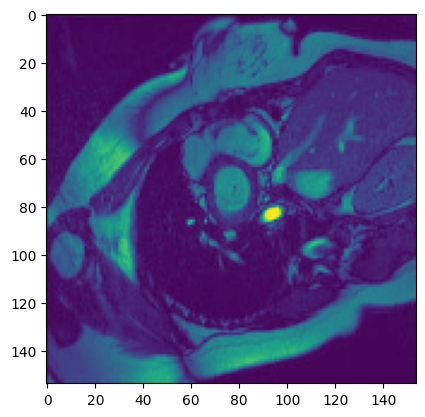

In [6]:
# Resizing images to standard dimensions
trainList = []
for i in range(len(x_train)):
  resized = cv2.resize(x_train[i][0], (154, 154))
  plt.imshow(resized)
  trainList.append(resized)
newXtrain = np.array(trainList)

testList = []
for i in range(len(x_test)):
  resized = cv2.resize(x_test[i][0], (154, 154))
  testList.append(resized)
newXtest = np.array(testList)


In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(newXtrain, y_train, test_size=0.2, random_state=42)
x_test = newXtest

In [8]:
mean = x_train.mean(axis=0)
std  = x_train.std(axis=0)
x_train = (x_train-mean)/std
x_valid = (x_valid-mean)/std
x_test  = (x_test-mean)/std

In [9]:
nb_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)
y_test  = to_categorical(y_test, nb_classes)

# **Training**

In [10]:
x_train.shape #flattened

(80, 154, 154)

In [11]:
y_train.shape

(80, 5)

In [12]:
# early stopping
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.2

In [13]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 48  # length of the filter/kernel in the convolutional layers
window_size     = x_train.shape[1] # the window size defined by the dataset
nb_features     = x_train.shape[1] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train.shape[1] # the number of outputs (defined by the target data)

In [14]:
# Model Definition
model = Sequential()
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
model.add(Dropout(0.1))
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(nb_outputs, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
network_history = model.fit(x_train, y_train,
                            validation_data=(x_valid,y_valid),
                            batch_size=5,
                            epochs=500,
                            verbose=1,
                            callbacks=[es])

Epoch 1/500
16/16 [==============================] - 4s 47ms/step - loss: 2.9301 - accuracy: 0.1500 - val_loss: 2.3929 - val_accuracy: 0.2500
Epoch 2/500
16/16 [==============================] - 0s 29ms/step - loss: 2.0045 - accuracy: 0.3750 - val_loss: 1.7360 - val_accuracy: 0.3000
Epoch 3/500
16/16 [==============================] - 0s 29ms/step - loss: 1.3678 - accuracy: 0.5250 - val_loss: 1.8538 - val_accuracy: 0.3000
Epoch 4/500
16/16 [==============================] - 0s 25ms/step - loss: 1.1996 - accuracy: 0.5000 - val_loss: 1.7142 - val_accuracy: 0.2500
Epoch 5/500
16/16 [==============================] - 0s 24ms/step - loss: 0.8765 - accuracy: 0.6875 - val_loss: 1.9554 - val_accuracy: 0.2500
Epoch 6/500
16/16 [==============================] - 0s 25ms/step - loss: 0.7480 - accuracy: 0.7375 - val_loss: 2.3327 - val_accuracy: 0.1500
Epoch 7/500
16/16 [==============================] - 0s 24ms/step - loss: 0.5885 - accuracy: 0.8000 - val_loss: 2.8382 - val_accuracy: 0.1500
